# 指纹图像增强

In [1]:
import numpy as np
import math
import scipy.ndimage
import scipy
import cv2
from scipy import ndimage
from scipy import signal
import matplotlib.pylab as plt
import sys

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 22 02:51:53 2016
@author: utkarsh
"""



# FREQEST - Estimate fingerprint ridge frequency within image block
#
# Function to estimate the fingerprint ridge frequency within a small block
# of a fingerprint image.  This function is used by RIDGEFREQ
#
# Usage:
#  freqim =  freqest(im, orientim, windsze, minWaveLength, maxWaveLength)
#
# Arguments:
#         im       - Image block to be processed.
#         orientim - Ridge orientation image of image block.
#         windsze  - Window length used to identify peaks. This should be
#                    an odd integer, say 3 or 5.
#         minWaveLength,  maxWaveLength - Minimum and maximum ridge
#                     wavelengths, in pixels, considered acceptable.
# 
# Returns:
#         freqim    - An image block the same size as im with all values
#                     set to the estimated ridge spatial frequency.  If a
#                     ridge frequency cannot be found, or cannot be found
#                     within the limits set by min and max Wavlength
#                     freqim is set to zeros.
#
# Suggested parameters for a 500dpi fingerprint image
#   freqim = freqest(im,orientim, 5, 5, 15);
#
# See also:  RIDGEFREQ, RIDGEORIENT, RIDGESEGMENT

### REFERENCES

# Peter Kovesi 
# School of Computer Science & Software Engineering
# The University of Western Australia
# pk at csse uwa edu au
# http://www.csse.uwa.edu.au/~pk
def frequest(im,orientim,windsze,minWaveLength,maxWaveLength):
    rows,cols = np.shape(im);
    
    # Find mean orientation within the block. This is done by averaging the
    # sines and cosines of the doubled angles before reconstructing the
    # angle again.  This avoids wraparound problems at the origin.
        
    
    cosorient = np.mean(np.cos(2*orientim));
    sinorient = np.mean(np.sin(2*orientim));    
    orient = math.atan2(sinorient,cosorient)/2;
    
    # Rotate the image block so that the ridges are vertical    
    
    #ROT_mat = cv2.getRotationMatrix2D((cols/2,rows/2),orient/np.pi*180 + 90,1)    
    #rotim = cv2.warpAffine(im,ROT_mat,(cols,rows))
    rotim = scipy.ndimage.rotate(im,orient/np.pi*180 + 90,axes=(1,0),reshape = False,order = 3,mode = 'nearest');

    # Now crop the image so that the rotated image does not contain any
    # invalid regions.  This prevents the projection down the columns
    # from being mucked up.
    
    cropsze = int(np.fix(rows/np.sqrt(2)));
    offset = int(np.fix((rows-cropsze)/2));
    rotim = rotim[offset:offset+cropsze][:,offset:offset+cropsze];
    
    # Sum down the columns to get a projection of the grey values down
    # the ridges.
    
    proj = np.sum(rotim,axis = 0);
    dilation = scipy.ndimage.grey_dilation(proj, windsze,structure=np.ones(windsze));

    temp = np.abs(dilation - proj);
    
    peak_thresh = 2;    
    
    maxpts = (temp<peak_thresh) & (proj > np.mean(proj));
    maxind = np.where(maxpts);
    
    rows_maxind,cols_maxind = np.shape(maxind);
    
    # Determine the spatial frequency of the ridges by divinding the
    # distance between the 1st and last peaks by the (No of peaks-1). If no
    # peaks are detected, or the wavelength is outside the allowed bounds,
    # the frequency image is set to 0    
    
    if(cols_maxind<2):
        freqim = np.zeros(im.shape);
    else:
        NoOfPeaks = cols_maxind;
        waveLength = (maxind[0][cols_maxind-1] - maxind[0][0])/(NoOfPeaks - 1);
        if waveLength>=minWaveLength and waveLength<=maxWaveLength:
            freqim = 1/np.double(waveLength) * np.ones(im.shape);
        else:
            freqim = np.zeros(im.shape);
        
    return(freqim);

In [16]:
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 22 03:15:03 2016
@author: utkarsh
"""


# RIDGEFILTER - enhances fingerprint image via oriented filters
#
# Function to enhance fingerprint image via oriented filters
#
# Usage:
#  newim =  ridgefilter(im, orientim, freqim, kx, ky, showfilter)
#
# Arguments:
#         im       - Image to be processed.
#         orientim - Ridge orientation image, obtained from RIDGEORIENT.
#         freqim   - Ridge frequency image, obtained from RIDGEFREQ.
#         kx, ky   - Scale factors specifying the filter sigma relative
#                    to the wavelength of the filter.  This is done so
#                    that the shapes of the filters are invariant to the
#                    scale.  kx controls the sigma in the x direction
#                    which is along the filter, and hence controls the
#                    bandwidth of the filter.  ky controls the sigma
#                    across the filter and hence controls the
#                    orientational selectivity of the filter. A value of
#                    0.5 for both kx and ky is a good starting point.
#         showfilter - An optional flag 0/1.  When set an image of the
#                      largest scale filter is displayed for inspection.
# 
# Returns:
#         newim    - The enhanced image
#
# See also: RIDGEORIENT, RIDGEFREQ, RIDGESEGMENT

# Reference: 
# Hong, L., Wan, Y., and Jain, A. K. Fingerprint image enhancement:
# Algorithm and performance evaluation. IEEE Transactions on Pattern
# Analysis and Machine Intelligence 20, 8 (1998), 777 789.

### REFERENCES

# Peter Kovesi  
# School of Computer Science & Software Engineering
# The University of Western Australia
# pk at csse uwa edu au
# http://www.csse.uwa.edu.au/~pk


def ridge_filter(im, orient, freq, kx, ky):
    angleInc = 3;
    im = np.double(im);
    rows,cols = im.shape;
    newim = np.zeros((rows,cols));
    
    freq_1d = np.reshape(freq,(1,rows*cols));
    ind = np.where(freq_1d>0);
    
    ind = np.array(ind);
    ind = ind[1,:];    
    
    # Round the array of frequencies to the nearest 0.01 to reduce the
    # number of distinct frequencies we have to deal with.    
    
    non_zero_elems_in_freq = freq_1d[0][ind]; 
    non_zero_elems_in_freq = np.double(np.round((non_zero_elems_in_freq*100)))/100;
    
    unfreq = np.unique(non_zero_elems_in_freq);

    # Generate filters corresponding to these distinct frequencies and
    # orientations in 'angleInc' increments.
    
    sigmax = 1/unfreq[0]*kx;
    sigmay = 1/unfreq[0]*ky;
    
    sze = np.round(3*np.max([sigmax,sigmay]));
    
    x,y = np.meshgrid(np.linspace(-sze,sze,(2*sze + 1)),np.linspace(-sze,sze,(2*sze + 1)));
    
    reffilter = np.exp(-(( (np.power(x,2))/(sigmax*sigmax) + (np.power(y,2))/(sigmay*sigmay)))) * np.cos(2*np.pi*unfreq[0]*x); # this is the original gabor filter
    
    filt_rows, filt_cols = reffilter.shape;    
    
    gabor_filter = np.array(np.zeros((int(180/angleInc),filt_rows,filt_cols)));
    
    for o in range(0,int(180/angleInc)):
        
        # Generate rotated versions of the filter.  Note orientation
        # image provides orientation *along* the ridges, hence +90
        # degrees, and imrotate requires angles +ve anticlockwise, hence
        # the minus sign.        
        
        rot_filt = scipy.ndimage.rotate(reffilter,-(o*angleInc + 90),reshape = False);
        gabor_filter[o] = rot_filt;
                
    # Find indices of matrix points greater than maxsze from the image
    # boundary
    
    maxsze = int(sze);   

    temp = freq>0;    
    validr,validc = np.where(temp)    
    
    temp1 = validr>maxsze;
    temp2 = validr<rows - maxsze;
    temp3 = validc>maxsze;
    temp4 = validc<cols - maxsze;
    
    final_temp = temp1 & temp2 & temp3 & temp4;    
    
    finalind = np.where(final_temp);
    
    # Convert orientation matrix values from radians to an index value
    # that corresponds to round(degrees/angleInc)    
    
    maxorientindex = np.round(180/angleInc);
    orientindex = np.round(orient/np.pi*180/angleInc);
    
    #do the filtering    
    
    for i in range(0,rows):
        for j in range(0,cols):
            if(orientindex[i][j] < 1):
                orientindex[i][j] = orientindex[i][j] + maxorientindex;
            if(orientindex[i][j] > maxorientindex):
                orientindex[i][j] = orientindex[i][j] - maxorientindex;
    finalind_rows,finalind_cols = np.shape(finalind);
    sze = int(sze);
    for k in range(0,finalind_cols):
        r = validr[finalind[0][k]];
        c = validc[finalind[0][k]];
        
        img_block = im[r-sze:r+sze + 1][:,c-sze:c+sze + 1];
        
        newim[r][c] = np.sum(img_block * gabor_filter[int(orientindex[r][c]) - 1]);
        
    return(newim);    

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 19 12:14:49 2016
@author: utkarsh
"""


# RIDGEFREQ - Calculates a ridge frequency image
#
# Function to estimate the fingerprint ridge frequency across a
# fingerprint image. This is done by considering blocks of the image and
# determining a ridgecount within each block by a call to FREQEST.
#
# Usage:
#  [freqim, medianfreq] =  ridgefreq(im, mask, orientim, blksze, windsze, ...
#                                    minWaveLength, maxWaveLength)
#
# Arguments:
#         im       - Image to be processed.
#         mask     - Mask defining ridge regions (obtained from RIDGESEGMENT)
#         orientim - Ridge orientation image (obtained from RIDGORIENT)
#         blksze   - Size of image block to use (say 32) 
#         windsze  - Window length used to identify peaks. This should be
#                    an odd integer, say 3 or 5.
#         minWaveLength,  maxWaveLength - Minimum and maximum ridge
#                     wavelengths, in pixels, considered acceptable.
# 
# Returns:
#         freqim     - An image  the same size as im with  values set to
#                      the estimated ridge spatial frequency within each
#                      image block.  If a  ridge frequency cannot be
#                      found within a block, or cannot be found within the
#                      limits set by min and max Wavlength freqim is set
#                      to zeros within that block.
#         medianfreq - Median frequency value evaluated over all the
#                      valid regions of the image.
#
# Suggested parameters for a 500dpi fingerprint image
#   [freqim, medianfreq] = ridgefreq(im,orientim, 32, 5, 5, 15);
#

# See also: RIDGEORIENT, FREQEST, RIDGESEGMENT

# Reference: 
# Hong, L., Wan, Y., and Jain, A. K. Fingerprint image enhancement:
# Algorithm and performance evaluation. IEEE Transactions on Pattern
# Analysis and Machine Intelligence 20, 8 (1998), 777 789.

### REFERENCES

# Peter Kovesi  
# School of Computer Science & Software Engineering
# The University of Western Australia
# pk at csse uwa edu au
# http://www.csse.uwa.edu.au/~pk



# import numpy as np
# #import math
# #import scipy.ndimage
# from frequest import frequest

def ridge_freq(im, mask, orient, blksze, windsze,minWaveLength, maxWaveLength):
    rows,cols = im.shape;
    freq = np.zeros((rows,cols));
    
    for r in range(0,rows-blksze,blksze):
        for c in range(0,cols-blksze,blksze):
            blkim = im[r:r+blksze][:,c:c+blksze];
            blkor = orient[r:r+blksze][:,c:c+blksze];
            
            
            freq[r:r+blksze][:,c:c+blksze] = frequest(blkim,blkor,windsze,minWaveLength,maxWaveLength);
    
    freq = freq*mask;
    freq_1d = np.reshape(freq,(1,rows*cols));
    ind = np.where(freq_1d>0);
    
    ind = np.array(ind);
    ind = ind[1,:];    
    
    non_zero_elems_in_freq = freq_1d[0][ind];    
    
    meanfreq = np.mean(non_zero_elems_in_freq);
    medianfreq = np.median(non_zero_elems_in_freq);         # does not work properly
    return(freq,meanfreq)

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 19 11:31:54 2016
@author: utkarsh
"""



# RIDGEORIENT - Estimates the local orientation of ridges in a fingerprint
#
# Usage:  [orientim, reliability, coherence] = ridgeorientation(im, gradientsigma,...
#                                             blocksigma, ...
#                                             orientsmoothsigma)
#
# Arguments:  im                - A normalised input image.
#             gradientsigma     - Sigma of the derivative of Gaussian
#                                 used to compute image gradients.
#             blocksigma        - Sigma of the Gaussian weighting used to
#                                 sum the gradient moments.
#             orientsmoothsigma - Sigma of the Gaussian used to smooth
#                                 the final orientation vector field. 
#                                 Optional: if ommitted it defaults to 0
# 
# Returns:    orientim          - The orientation image in radians.
#                                 Orientation values are +ve clockwise
#                                 and give the direction *along* the
#                                 ridges.
#             reliability       - Measure of the reliability of the
#                                 orientation measure.  This is a value
#                                 between 0 and 1. I think a value above
#                                 about 0.5 can be considered 'reliable'.
#                                 reliability = 1 - Imin./(Imax+.001);
#             coherence         - A measure of the degree to which the local
#                                 area is oriented.
#                                 coherence = ((Imax-Imin)./(Imax+Imin)).^2;
#
# With a fingerprint image at a 'standard' resolution of 500dpi suggested
# parameter values might be:
#
#    [orientim, reliability] = ridgeorient(im, 1, 3, 3);
#
# See also: RIDGESEGMENT, RIDGEFREQ, RIDGEFILTER

### REFERENCES

# May 2003      Original version by Raymond Thai,  
# January 2005  Reworked by Peter Kovesi           
# October 2011  Added coherence computation and orientsmoothsigma made optional
#
# School of Computer Science & Software Engineering
# The University of Western Australia
# pk at csse uwa edu au
# http://www.csse.uwa.edu.au/~pk


# import numpy as np;
# import cv2;
# from scipy import ndimage;
# from scipy import signal

def ridge_orient(im, gradientsigma, blocksigma, orientsmoothsigma):
    rows,cols = im.shape;
    #Calculate image gradients.
    sze = np.fix(6*gradientsigma);
    if np.remainder(sze,2) == 0:
        sze = sze+1;
        
    gauss = cv2.getGaussianKernel(np.int(sze),gradientsigma);
    f = gauss * gauss.T;
    
    fy,fx = np.gradient(f);     #Gradient of Gaussian
    
    #Gx = ndimage.convolve(np.double(im),fx);
    #Gy = ndimage.convolve(np.double(im),fy);
    
    Gx = signal.convolve2d(im,fx,mode='same');    
    Gy = signal.convolve2d(im,fy,mode='same');
    
    Gxx = np.power(Gx,2);
    Gyy = np.power(Gy,2);
    Gxy = Gx*Gy;
    
    #Now smooth the covariance data to perform a weighted summation of the data.    
    
    sze = np.fix(6*blocksigma);
    
    gauss = cv2.getGaussianKernel(np.int(sze),blocksigma);
    f = gauss * gauss.T;
    
    Gxx = ndimage.convolve(Gxx,f);
    Gyy = ndimage.convolve(Gyy,f);
    Gxy = 2*ndimage.convolve(Gxy,f);
    
    # Analytic solution of principal direction
    denom = np.sqrt(np.power(Gxy,2) + np.power((Gxx - Gyy),2)) + np.finfo(float).eps;
    
    sin2theta = Gxy/denom;            # Sine and cosine of doubled angles
    cos2theta = (Gxx-Gyy)/denom;
    
    
    if orientsmoothsigma:
        sze = np.fix(6*orientsmoothsigma);
        if np.remainder(sze,2) == 0:
            sze = sze+1;    
        gauss = cv2.getGaussianKernel(np.int(sze),orientsmoothsigma);
        f = gauss * gauss.T;
        cos2theta = ndimage.convolve(cos2theta,f); # Smoothed sine and cosine of
        sin2theta = ndimage.convolve(sin2theta,f); # doubled angles
    
    orientim = np.pi/2 + np.arctan2(sin2theta,cos2theta)/2;
    return(orientim);

In [6]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 18 23:04:30 2016
@author: utkarsh
"""



# RIDGESEGMENT - Normalises fingerprint image and segments ridge region
#
# Function identifies ridge regions of a fingerprint image and returns a
# mask identifying this region.  It also normalises the intesity values of
# the image so that the ridge regions have zero mean, unit standard
# deviation.
#
# This function breaks the image up into blocks of size blksze x blksze and
# evaluates the standard deviation in each region.  If the standard
# deviation is above the threshold it is deemed part of the fingerprint.
# Note that the image is normalised to have zero mean, unit standard
# deviation prior to performing this process so that the threshold you
# specify is relative to a unit standard deviation.
#
# Usage:   [normim, mask, maskind] = ridgesegment(im, blksze, thresh)
#
# Arguments:   im     - Fingerprint image to be segmented.
#              blksze - Block size over which the the standard
#                       deviation is determined (try a value of 16).
#              thresh - Threshold of standard deviation to decide if a
#                       block is a ridge region (Try a value 0.1 - 0.2)
#
# Returns:     normim - Image where the ridge regions are renormalised to
#                       have zero mean, unit standard deviation.
#              mask   - Mask indicating ridge-like regions of the image, 
#                       0 for non ridge regions, 1 for ridge regions.
#              maskind - Vector of indices of locations within the mask. 
#
# Suggested values for a 500dpi fingerprint image:
#
#   [normim, mask, maskind] = ridgesegment(im, 16, 0.1)
#
# See also: RIDGEORIENT, RIDGEFREQ, RIDGEFILTER

### REFERENCES

# Peter Kovesi         
# School of Computer Science & Software Engineering
# The University of Western Australia
# pk at csse uwa edu au
# http://www.csse.uwa.edu.au/~pk


# import numpy as np

def normalise(img,mean,std):
    normed = (img - np.mean(img))/(np.std(img));    
    return(normed)
    
def ridge_segment(im,blksze,thresh):
    
    rows,cols = im.shape;    
    
    im = normalise(im,0,1);    # normalise to get zero mean and unit standard deviation
    
    
    new_rows =  np.int(blksze * np.ceil((np.float(rows))/(np.float(blksze))))
    new_cols =  np.int(blksze * np.ceil((np.float(cols))/(np.float(blksze))))
    
    padded_img = np.zeros((new_rows,new_cols));
    stddevim = np.zeros((new_rows,new_cols));
    
    padded_img[0:rows][:,0:cols] = im;
    
    for i in range(0,new_rows,blksze):
        for j in range(0,new_cols,blksze):
            block = padded_img[i:i+blksze][:,j:j+blksze];
            
            stddevim[i:i+blksze][:,j:j+blksze] = np.std(block)*np.ones(block.shape)
    
    stddevim = stddevim[0:rows][:,0:cols]
                    
    mask = stddevim > thresh;
    
    mean_val = np.mean(im[mask]);
    
    std_val = np.std(im[mask]);
    
    normim = (im - mean_val)/(std_val);
    
    return(normim,mask)

In [7]:
def image_enhance(img):
    blksze = 16;
    thresh = 0.1;
    normim,mask = ridge_segment(img,blksze,thresh);             # normalise the image and find a ROI


    gradientsigma = 1;
    blocksigma = 7;
    orientsmoothsigma = 7;
    orientim = ridge_orient(normim, gradientsigma, blocksigma, orientsmoothsigma);              # find orientation of every pixel


    blksze = 38;
    windsze = 5;
    minWaveLength = 5;
    maxWaveLength = 15;
    freq,medfreq = ridge_freq(normim, mask, orientim, blksze, windsze, minWaveLength,maxWaveLength);    #find the overall frequency of ridges
    
    
    freq = medfreq*mask;
    kx = 0.65;ky = 0.65;
    newim = ridge_filter(normim, orientim, freq, kx, ky);       # create gabor filter and do the actual filtering
    
    
    #th, bin_im = cv2.threshold(np.uint8(newim),0,255,cv2.THRESH_BINARY);
    return(newim < -3)

loading sample image


C:\Users\jenson\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.
C:\Users\jenson\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\jenson\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


True

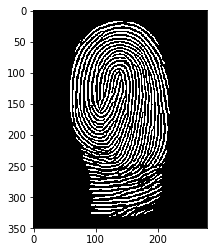

In [21]:
# if(len(sys.argv)<2):
print('loading sample image');
img_name = 'fingure_1.jpg'
img = scipy.ndimage.imread('../datas/fingure_1.jpg');
# elif(len(sys.argv) >= 2):
#     img_name = sys.argv[1];
#     img = scipy.ndimage.imread(sys.argv[1]);
    
if(len(img.shape)>2):
    # img = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)
    img = np.dot(img[...,:3], [0.299, 0.587, 0.114]);

rows,cols = np.shape(img);
aspect_ratio = np.double(rows)/np.double(cols);

new_rows = 350;             # randomly selected number
new_cols = new_rows/aspect_ratio;

#img = cv2.resize(img,(new_rows,new_cols));
img = scipy.misc.imresize(img,(np.int(new_rows),np.int(new_cols)));

enhanced_img = image_enhance(img);    

# if(1):
#     print('saving the image')
#     scipy.misc.imsave('../temp/' + img_name,enhanced_img);
# else:
plt.imshow(enhanced_img,cmap = 'Greys_r');
# cv2.imwrite(enhanced_img,'../temp/fingure_enhanced.jpg')
cv2.imwrite('../temp/fingure_enhanced.jpg',img, [int( cv2.IMWRITE_JPEG_QUALITY), 100])

参考：

[1].https://github.com/Utkarsh-Deshmukh/Fingerprint-Enhancement-Python